In [1]:
import pandas as pd

mooc = pd.read_csv('big_student_clear_third_version.csv')

mooc = mooc.drop(columns=['Unnamed: 0','gender','incomplete_flag']) # drop columns with no metadata about their content

mooc = mooc.rename(columns={"userid_DI": "userid", "final_cc_cname_DI": "country","LoE_DI":"education",
                            "start_time_DI":"start_time", "last_event_DI":"last_event" }) # rename

#  Data Cleaning

In [2]:
from datetime import datetime

mooc['last_event'] = pd.to_datetime(mooc['last_event'])   # create a column for the duration of studies
mooc['start_time'] = pd.to_datetime(mooc['start_time'])
mooc['duration'] = mooc['last_event'] - mooc['start_time']

mooc = mooc.drop(mooc[mooc['duration']< '0 days'].index) # drop the 1231 lines with negative duration

mooc = mooc.drop(mooc[mooc['certified']==1][mooc['grade']< 0.5].index) # drop the 1 line that someone 
                                                                       # graduated with grade less than 50 %
    
# drop the lines where age < 5
mooc = mooc.drop(mooc[mooc['age']< 5].index)  # 279 rows

C:\Users\B590\AppData\Local\Temp\ipykernel_8604\2693734390.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mooc = mooc.drop(mooc[mooc['certified']==1][mooc['grade']< 0.5].index) # drop the 1 line that someone


In [3]:
mooc.head()

,institute,course_id,year,semester,userid,viewed,explored,certified,country,education,grade,start_time,last_event,nevents,ndays_act,nplay_video,nchapters,nforum_posts,age,duration
0,HarvardX,PH207x,2012,Fall,MHxPC130313697,0,0,0,India,Bachelor's,0.0,2012-07-24,2013-07-27,6,3,197757,0,0,23,368 days
1,HarvardX,PH207x,2012,Fall,MHxPC130237753,1,0,0,United States,Secondary,0.0,2012-07-24,2012-12-24,107,8,7,2,0,19,153 days
2,HarvardX,CS50x,2012,Summer,MHxPC130202970,1,0,0,United States,Bachelor's,0.0,2012-07-24,2013-03-28,8,1,197757,1,0,24,247 days
3,HarvardX,CS50x,2012,Summer,MHxPC130223941,1,0,0,Other Middle East/Central Asia,Secondary,0.0,2012-07-24,2013-07-15,25,2,197757,4,0,20,356 days
4,HarvardX,PH207x,2012,Fall,MHxPC130317399,0,0,0,Australia,Master's,0.0,2012-07-24,2012-08-25,3,2,197757,0,0,32,32 days


In [4]:
# drop columns not usefull for the model

mooc = mooc.drop(columns=['course_id','userid','start_time','last_event','year','institute'])

In [5]:
# encode categorical columns 

categorical = ['semester', 'country', 'education']
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()

for i in categorical:
    mooc[i] = ord_enc.fit_transform(mooc[[i]])

In [6]:
mooc['duration'] = mooc['duration'].dt.days
mooc

,semester,viewed,explored,certified,country,education,grade,nevents,ndays_act,nplay_video,nchapters,nforum_posts,age,duration
0,0.0,0,0,0,10.0,0.0,0.0,6,3,197757,0,0,23,368
1,0.0,1,0,0,32.0,4.0,0.0,107,8,7,2,0,19,153
2,2.0,1,0,0,32.0,0.0,0.0,8,1,197757,1,0,24,247
3,2.0,1,0,0,19.0,4.0,0.0,25,2,197757,4,0,20,356
4,0.0,0,0,0,0.0,3.0,0.0,3,2,197757,0,0,32,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416916,1.0,1,0,0,24.0,3.0,0.0,29,1,197757,1,0,24,0
416917,1.0,1,0,0,3.0,0.0,0.0,97,1,4,2,0,22,0
416918,1.0,0,0,0,18.0,0.0,0.0,1,1,197757,0,0,22,0
416919,1.0,0,0,0,32.0,1.0,0.0,1,1,197757,0,0,34,0


# Model 

In [7]:
#split training set and test set

from sklearn.model_selection import train_test_split

X = mooc.drop('certified', axis=1)
y = mooc['certified']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=50)

In [8]:
# build models

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

dt = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=2)
lr = LogisticRegression(random_state=4)
models = [dt,rfc,lr]


def fit_predict_evaluate_model(model):
    
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    return (classification_report(y_test, predictions))
    

for m in models:
    print('/nModel : ',m,'\n',fit_predict_evaluate_model(m))

/nModel :  DecisionTreeClassifier(random_state=0) 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    120220
           1       0.98      0.98      0.98      4403

    accuracy                           1.00    124623
   macro avg       0.99      0.99      0.99    124623
weighted avg       1.00      1.00      1.00    124623

/nModel :  RandomForestClassifier(random_state=2) 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    120220
           1       0.98      0.99      0.99      4403

    accuracy                           1.00    124623
   macro avg       0.99      0.99      0.99    124623
weighted avg       1.00      1.00      1.00    124623



C:\Users\B590\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/nModel :  LogisticRegression(random_state=4) 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99    120220
           1       0.71      0.57      0.63      4403

    accuracy                           0.98    124623
   macro avg       0.85      0.78      0.81    124623
weighted avg       0.97      0.98      0.98    124623



From the evaluation metrics above, we conclude that Random Forest Classifier has better performance. 

In [9]:
predictions = rfc.predict(X_test)
print ('confusion matrix : \n',confusion_matrix(y_test,predictions))

confusion matrix : 
 [[120135     85]
 [    47   4356]]


The roc_auc_score is  0.9999685242813039


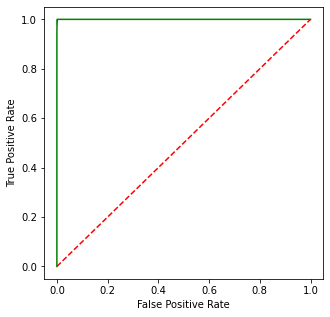

In [10]:
# ROC curve for the Random Forest Classifier

from sklearn.metrics import roc_curve, roc_auc_score
y_score = rfc.predict_proba(X_test)[:,1]
labels = list(y_test)
false_positive_rate, true_positive_rate, threshold = roc_curve(labels, y_score)

print ('The roc_auc_score is ',roc_auc_score(labels, y_score))

import matplotlib.pyplot as plt
plt.subplots(1, figsize=(5,5))
plt.plot(false_positive_rate, true_positive_rate,color='g')
plt.plot([0, 1], ls="--",color='r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Let's cut the huge dataset to the size of the dataset with the demographic data of the students. Now we can compare the best performances of the selected models and make conclusions on which type of data are better for predicting students dropout.

In [11]:
graduate  = mooc[mooc["certified"]==1][:2209]
dropout = graduates = mooc[mooc["certified"]==0][:1421]
small_mooc = pd.concat([graduate,dropout],axis=0)        # new data with the same proportions as demographic data

In [12]:
small_mooc

,semester,viewed,explored,certified,country,education,grade,nevents,ndays_act,nplay_video,nchapters,nforum_posts,age,duration
25,2.0,1,1,1,18.0,3.0,1.0,691,59,197757,12,0,29,286
123,0.0,1,1,1,6.0,4.0,1.0,219,59,197757,12,0,17,247
175,2.0,1,1,1,12.0,0.0,1.0,92,29,197757,9,0,25,274
206,0.0,1,1,1,10.0,0.0,1.0,28,15,197757,12,0,21,215
215,2.0,1,1,1,24.0,0.0,1.0,295,44,197757,12,0,21,289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,1.0,1,0,0,18.0,4.0,0.0,136,2,2,2,0,33,0
1501,1.0,1,0,0,2.0,0.0,0.0,6,2,1,1,0,25,149
1502,0.0,1,0,0,10.0,3.0,0.0,1017,9,272,3,6,29,102
1503,0.0,1,1,0,10.0,4.0,0.0,171,6,197757,12,0,27,178


In [13]:
X = small_mooc.drop('certified', axis=1)
y = small_mooc['certified']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=50)

In [14]:
for m in models:
    print('/nModel : ',m,'\n',fit_predict_evaluate_model(m))

/nModel :  DecisionTreeClassifier(random_state=0) 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       1.00      1.00      1.00       649

    accuracy                           1.00      1089
   macro avg       1.00      1.00      1.00      1089
weighted avg       1.00      1.00      1.00      1089

/nModel :  RandomForestClassifier(random_state=2) 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       1.00      1.00      1.00       649

    accuracy                           1.00      1089
   macro avg       1.00      1.00      1.00      1089
weighted avg       1.00      1.00      1.00      1089

/nModel :  LogisticRegression(random_state=4) 
               precision    recall  f1-score   support

           0       0.92      0.91      0.92       440
           1       0.94      0.95      0.94       649

    accuracy                  

C:\Users\B590\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# Random Forest Classifier has better performance here too.

predictions = rfc.predict(X_test)
print ('confusion matrix : \n',confusion_matrix(y_test,predictions))

confusion matrix : 
 [[439   1]
 [  0 649]]
